## **Assignment 5 - Building and Analyzing Markov State Models**
### **Hugo Manuel Alves Henriques e Silva, hugoalv@student.chalmers.se**

#### **How to run:**
`Run the cells below in order. Make sure to have the datasets in the same folder as the notebook.`

##### **1.** 
Write a program that reads the trajectory file.

The columns represent the dimensions. As you will see, you will be working with a two-dimensional system.

In [1126]:
import numpy as np

file = open("traj-2.txt", "r")
lines = file.readlines()
file.close()

x = []
y = []
for line in lines:
    x.append(float(line.split()[0]))
    y.append(float(line.split()[1]))


data = np.array([x, y]).T

#### **2.**
Discretize the trajectory into 100 clusters to create a one-dimensional discrete trajectory.

You may use common libraries (such as SciPy/Numpy). 

In [1127]:
from scipy.cluster.vq import kmeans2

np.random.seed(0)

default_num_clusters = 100

def get_state_clustering(num_clusters):

    _, states = kmeans2(data, num_clusters, minit='points')

    return states

default_states = get_state_clustering(default_num_clusters)

#### **3.**

Plot the trajectory itself as well as a 2D histogram.

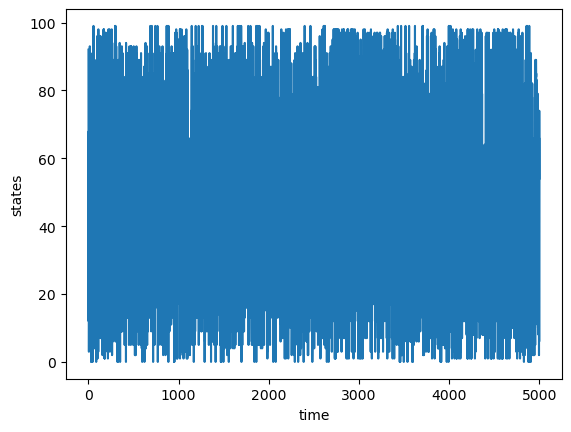

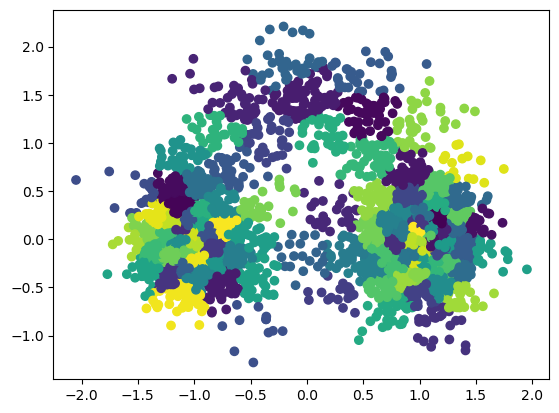

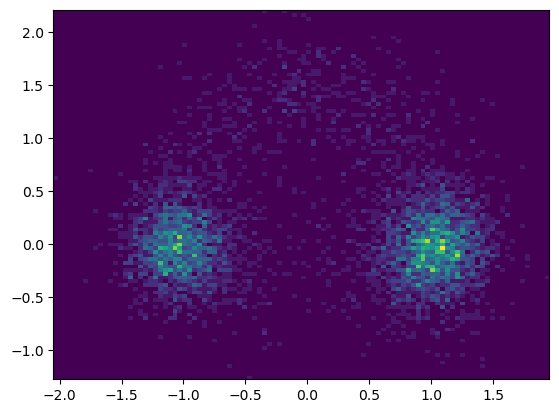

In [1128]:
import matplotlib.pyplot as plt
def plot_trajectory_2dhist(states):
    plt.plot(states)
    plt.ylabel('states')
    plt.xlabel('time')
    plt.show()

    plt.scatter(x, y, c=states)
    plt.show()

    plt.hist2d(x, y, bins=100)
    plt.show()

plot_trajectory_2dhist(default_states)

By analysing the obtained plots, especially the last 2, it is possible to visually identify the most visited regions of the system which would 

correspond to the macrostates. The points are coloured according to the cluster they belong to. We used 100 clusters for discretization. The 

highest concetration of points indicates the macrostates. We can argue about the existence of 3 macrostates, but it is clear that there exist 

at least 2 macrostates, corresponding the high concentration of points in the left and in the right of the plots.

#### **4.**
**Write a program that calculates the `count matrix` from the discretized trajectory. That is, an `n x n` matrix that, in its ijth element,** 

**contains the number of transitions from i to j and where `n` is the number of states.**

In [1129]:
def get_count_matrix(states, num_clusters):

    time_lag = 1

    count_matrix = np.zeros((num_clusters, num_clusters))

    for i in range(1, len(states), time_lag):
        current_cluster = states[i]
        previous_cluster = states[i-1]
        count_matrix[previous_cluster][current_cluster] += 1

    return count_matrix

default_count_matrix = get_count_matrix(default_states, default_num_clusters)

#### **5.**
**Based on the count matrix, calculate the `transition matrix` .That is, an `n x n` matrix that, in its ijth element, contains the transition**

**probability from i to j. Note that the rows sum to one! You may use the trivial estimator described in the lecture slides to calculate the**

**transition matrix.**

In [1130]:
def get_transition_matrix(count_matrix, num_clusters):

    transition_matrix = np.zeros((num_clusters, num_clusters))

    for i in range(num_clusters):
        row_sum = sum(count_matrix[i])
        for j in range(num_clusters):
            if row_sum != 0:
                transition_matrix[i][j] = count_matrix[i][j] / row_sum


    transition_matrix = np.nan_to_num(transition_matrix)

    return transition_matrix

default_transition_matrix = get_transition_matrix(default_count_matrix, default_num_clusters)

#### **6.**
**Make comments about what you can say so far about the underlying dynamical system that this trajectory stems from (e.g., how many macrostates** 

**do you observe? Can you guess which transition is the slowest?)**


##### **`Number of macrostates`**

Macrostates are characterized by groups of clusters, which correspond to the microstates, that have high intra-group 

transition probabilities and lower inter-group transitions.

- Firstly, we need to identify clusters that frequently transition between each other by analyzing the transition
  
   matrix. These are considered to be part of a macrostate.
  
- Secondly, we need to apply a threshold which will indicate us what probabilities we consider significant. Values 
  
  above the threshold will be considered as part of a macrostate.

- Thirdly, we are analysing the graph. A graph will be built where the nodes correspond to the clusters and the weights 
  
  of the edges correspond to the transition probabilities. The graph will be partitioned into communities by utilizing 
  
  graph theory. The communities will be considered as macrostates. We group the more densely connected nodes together, 
  
  have higher chances of transitioning among each other, and less connected to nodes outside their group.


**The number of macrostates is 2.**

##### **`Slowest transition`**

To find the slowest transition we will:

- Go through all the transitions between clusters from different macrostates which are typically slower than 
  
  transitions within the same macrostate. 

- Find the transition with the lowest probability. The transition with the lowest probability is the slowest one.

- We will be cautious with the transition probabilities. We want to avoid transitions with zero probability. We will 
  
  use a theshold to avoid this.

**The slowest transition is from cluster 8 to cluster 27 with probability 0.0127.**

In [1131]:
import networkx as nx
from networkx.algorithms import community

def calculate_macro_staes(transition_matrix, num_clusters):

    cluster_graph = nx.DiGraph()

    for i in range(num_clusters):
        cluster_graph.add_node(i)

    threshold = 0.01
    for i in range(num_clusters):
        for j in range(num_clusters):
            if transition_matrix[i][j] > threshold:
                cluster_graph.add_edge(i, j, weight=transition_matrix[i][j])

    communities = community.greedy_modularity_communities(cluster_graph)
    macrostates = []
    for c in communities:
        macrostate = []
        for node in c:
            macrostate.append(node)
        macrostates.append(macrostate)

    num_macrostates = len(macrostates)
    print("Number of macrostates: ", num_macrostates)
    for i in range(num_macrostates):
        print("Macrostate ", i+1, ": ", macrostates[i])

    return macrostates

default_macrostates = calculate_macro_staes(default_transition_matrix, default_num_clusters)


Number of macrostates:  2
Macrostate  1 :  [0, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 16, 18, 19, 20, 21, 22, 28, 29, 32, 33, 34, 35, 37, 38, 39, 40, 41, 43, 44, 46, 48, 50, 53, 54, 56, 60, 61, 62, 65, 66, 69, 70, 71, 72, 73, 74, 75, 78, 81, 82, 83, 84, 85, 87, 89, 91, 93, 94, 99]
Macrostate  2 :  [1, 3, 7, 12, 15, 17, 23, 24, 25, 26, 27, 30, 31, 36, 42, 45, 47, 49, 51, 52, 55, 57, 58, 59, 63, 64, 67, 68, 76, 77, 79, 80, 86, 88, 90, 92, 95, 96, 97, 98]


In [1132]:
def different_macrostates(c1, c2, macrostates):
        for macrostate in macrostates:
            if c1 in macrostate and c2 in macrostate:
                return False
        return True

def find_slowest_transition(macrostates, transition_matrix, num_clusters):
    threshold = 0.01
    slowest_trans = None
    lowest_prob = float('inf')

    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j and different_macrostates(i, j, macrostates):
                if transition_matrix[i][j] < lowest_prob:
                    if transition_matrix[i][j] < threshold:
                        continue
                    lowest_prob = transition_matrix[i][j]
                    slowest_trans = (i, j)

    print("Slowest Transition:", slowest_trans)
    print("Probability:", round(lowest_prob, 4))

find_slowest_transition(default_macrostates, default_transition_matrix, default_num_clusters)


Slowest Transition: (8, 27)
Probability: 0.0127


#### **7.**

**Calculate the eigenvalues from the obtained transition matrix from `T(τ)`. What can you say about the timescale of the**

**slowest processes? Assume a lag time `τ`. You may use common software packages like numpy to do the eigendecomposition.**

**It is possible that you get complex values for the eigenvalues/eigenvector. In that case you may discard the imaginary**

**part. Note that you can easily convert the eigenvalues into timescales (check lecture notes for that).**

In [1133]:
def get_eigenvalues(transition_matrix):

    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix)

    eigen_tuples = []

    for i in range(1, len(eigenvalues)):
        if eigenvalues[i].real > 0:
            eigen_tuples.append((i, eigenvalues[i].real, eigenvectors[:,i].real))
        
    eigen_tuples.sort(key=lambda x: x[1], reverse=True)

    num_eigenvals_to_print = 4
    if len(eigen_tuples) < num_eigenvals_to_print:
        num_eigenvals_to_print = len(eigen_tuples)

    for i in range(num_eigenvals_to_print):
        print("Eigenvalue", eigen_tuples[i][0] + 1, ":", eigen_tuples[i][1])

    return eigen_tuples

default_eigen_tuples = get_eigenvalues(default_transition_matrix)

Eigenvalue 2 : 0.9880509815075704
Eigenvalue 3 : 0.8987969156989578
Eigenvalue 4 : 0.673866419482109
Eigenvalue 5 : 0.5810165378753325


The largest eigenvalue is 1 and represents the steady-state, and the magnitude of the second-largest eigenvalue 

indicates the timescale of the slowest process. This the rate at which the system transitions away from its slowest

process towards equilibrium.

Timescale 2 : 83.18788036868298
Timescale 3 : 9.372231947601929
Timescale 4 : 2.5334197434032153
Timescale 5 : 1.8417018305023822


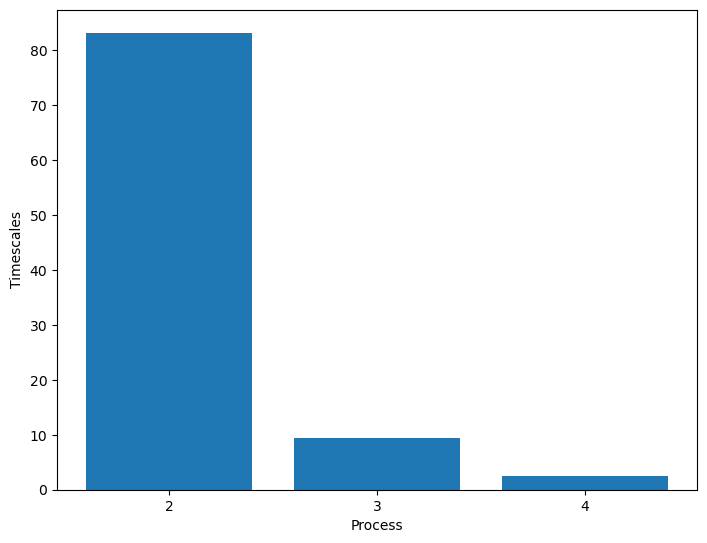

In [1134]:
def get_timescales(eigen_tuples, time_lag):
    timescales = []
    for i in range(len(eigen_tuples)):
        timescales.append((i+1, -time_lag / np.log(eigen_tuples[i][1])))
    timescales.sort(key=lambda x: x[1], reverse=True)

    num_timescale_to_print = 4
    if len(timescales) < num_timescale_to_print:
        num_timescale_to_print = len(timescales)

    for i in range(num_timescale_to_print):
        print("Timescale", timescales[i][0] + 1, ":", timescales[i][1])

    if len(timescales) < 3:
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1, 1])
        plt.bar([2, 3], [timescales[0][1], timescales[1][1]])
        plt.ylabel('Timescales')
        plt.xlabel('Process')
        ax.set_xticks([2, 3])
        plt.show()
    else:
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1, 1])
        plt.bar([2, 3, 4], [timescales[0][1], timescales[1][1], timescales[2][1]])
        plt.ylabel('Timescales')
        plt.xlabel('Process')
        ax.set_xticks([2, 3, 4])
        plt.show()

    return timescales

default_timescales = get_timescales(default_eigen_tuples, 1)


From the observed plot, it is clear that there exists only one slow process. The timescale of the slowest process is around 80. The third 

process is approximately 10 and the fourth process is approximately 3. Using the eigenvectors, we see that the slowest process belongs to the 

transition between macrostates 1 and 2.

#### **8.**

**Visualise the first few eigenfunctions of the system depending on how many slow processes you observed**

**(keyword: spectral gap). Describe what the eigenfunctions tell you about the system in question.**

**Your visualization may look something like this: `plt.scatter(*traj.T, c=eigvecs[i][dtraj])`**

##### **`The spectral gap`**

- Significant difference in the magnitude of eigenvalues. 
  
- Helps in identifying how many slow processes are present in the system.
  
- For example, a large gap after the second largest eigenvalue suggests one primary slow process.


##### **`Eigenfunctions`**

- Eigenfunctions are the eigenvectors of the transition matrix.

- We are going to select, based on the spectral gap, the first few eigenfunctions of the system, which correspond to 
  
  the largest eigenvalues, exluding the first one which is always 1.

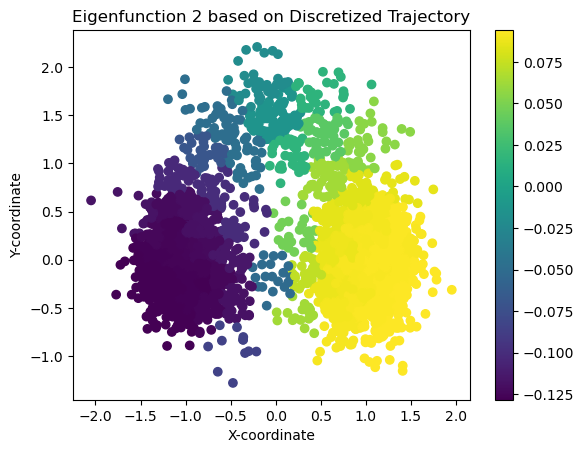

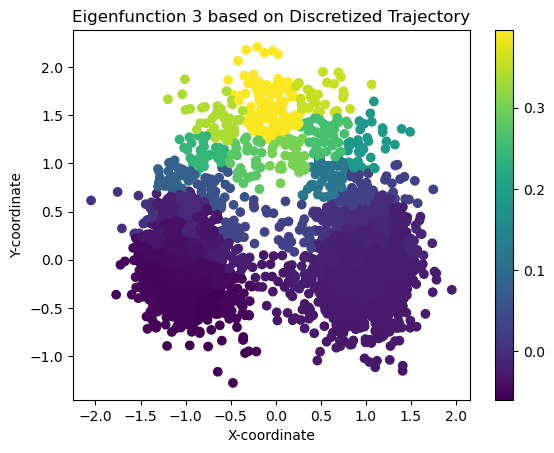

In [1135]:
num_eigenfunctions = 2

eigenvectors = np.array([eigen_tuple[2] for eigen_tuple in default_eigen_tuples])

for i in range(num_eigenfunctions):
    plt.figure()
    plt.scatter(data[:, 0], data[:, 1], c=eigenvectors[i, default_states])
    plt.title(f"Eigenfunction {i+2} based on Discretized Trajectory")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.colorbar()
    plt.show()

The transition of yellowish ligter dots to blueish darker dots indicates the existence of a slow process. The magnitude of the yellow dots is 

greater than the magnitude of the blue dots.

By analyzing the eigenfunctions we can identify the slowest process. The slowest process is the transition between macrostates 1 and 2.

Although, by the second eigenfunction we can argue about the existence of a second slow process. The second slow process could be the 

transition between macrostates 2 and 3 if we consider the existence of a third macrostate.

##### **`9`**

**Discretize the continuous trajectory again (trajectory file). This time in:**

- **3**

- **10**
  
- **100**
  
- **1000**

**states and visualize the leading eigenfunctions and timescales as a function of number of states (3, 10, 100, 1000). Comment on the quality of** 

**the discretization as the number of states increase. Also, do you see a difference in the estimated timescale of the slowest process as the**

**number of states increases? Comment on why or why not you observe these differences.**

------------------------------------
Discretization Value: 3
------------------------------------
Number of macrostates:  2
Macrostate  1 :  [0, 2]
Macrostate  2 :  [1]
Eigenvalue 2 : 0.9999999999999999
Eigenvalue 3 : 0.9785564873460725
Timescale 2 : 9007199254740992.0
Timescale 3 : 46.132344287163356


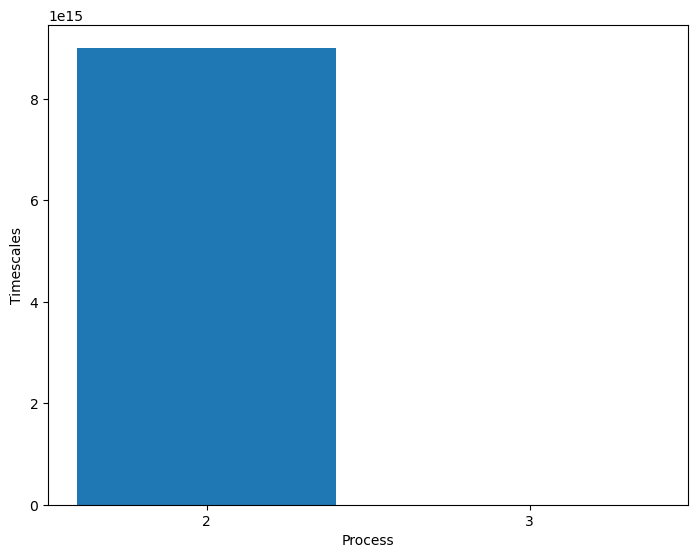

------------------------------------
Discretization Value: 10
------------------------------------
Number of macrostates:  3
Macrostate  1 :  [0, 1, 5, 6]
Macrostate  2 :  [8, 3, 4, 7]
Macrostate  3 :  [9, 2]
Eigenvalue 2 : 0.9810787679072362
Eigenvalue 3 : 0.8224520645040433
Eigenvalue 4 : 0.527696455390161
Eigenvalue 5 : 0.39915009453936234
Timescale 2 : 52.34908905500405
Timescale 3 : 5.116003374124651
Timescale 4 : 1.564372221888476
Timescale 5 : 1.088829123157682


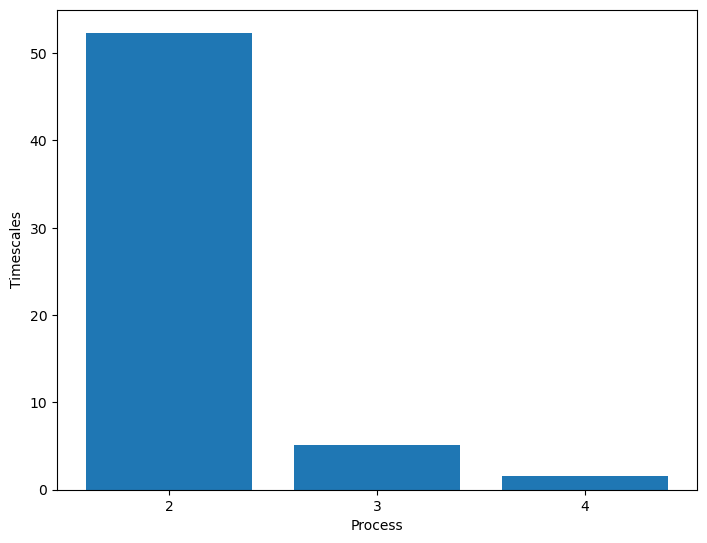

------------------------------------
Discretization Value: 100
------------------------------------
Number of macrostates:  2
Macrostate  1 :  [0, 3, 6, 7, 8, 11, 12, 18, 19, 21, 24, 25, 26, 27, 28, 30, 33, 34, 36, 37, 38, 39, 41, 43, 44, 46, 47, 51, 54, 56, 58, 59, 60, 61, 62, 64, 67, 70, 72, 73, 74, 75, 76, 78, 80, 81, 85, 87, 88, 89, 91, 92, 93, 94, 95, 98, 99]
Macrostate  2 :  [1, 2, 4, 5, 9, 10, 13, 14, 15, 16, 17, 20, 22, 23, 29, 31, 32, 35, 40, 42, 45, 48, 49, 50, 52, 53, 55, 57, 63, 65, 66, 68, 69, 71, 77, 79, 82, 83, 84, 86, 90, 96, 97]
Eigenvalue 2 : 0.9877630049144746
Eigenvalue 3 : 0.8957230838447648
Eigenvalue 4 : 0.6770066015688445
Eigenvalue 5 : 0.5659795849926608
Timescale 2 : 81.21838244541547
Timescale 3 : 9.080675006352884
Timescale 4 : 2.5636144590884267
Timescale 5 : 1.7568601469053877


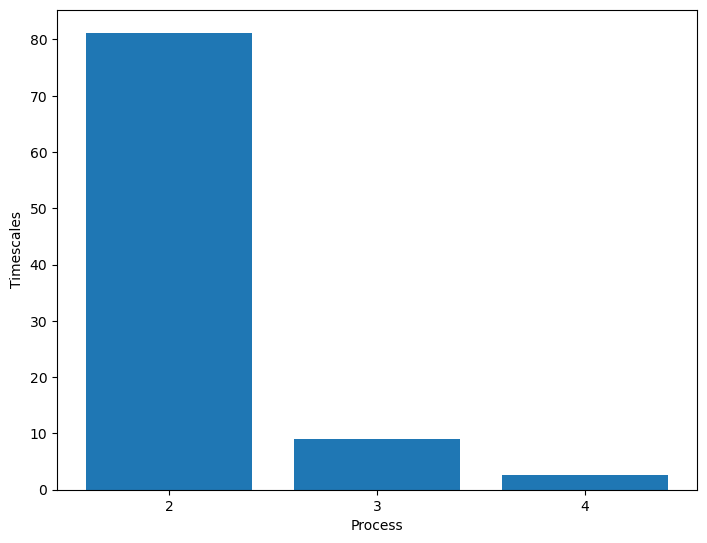

------------------------------------
Discretization Value: 1000
------------------------------------
Number of macrostates:  4
Macrostate  1 :  [1, 5, 6, 9, 10, 12, 14, 15, 17, 18, 20, 23, 24, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 42, 46, 52, 55, 56, 57, 58, 59, 60, 62, 65, 72, 75, 76, 77, 79, 80, 81, 83, 86, 88, 90, 91, 92, 93, 97, 100, 102, 103, 105, 111, 113, 115, 116, 117, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 136, 137, 139, 141, 142, 143, 144, 147, 148, 150, 153, 154, 161, 162, 164, 165, 169, 171, 172, 177, 180, 181, 189, 190, 192, 194, 198, 203, 205, 207, 208, 210, 213, 214, 217, 219, 220, 221, 222, 223, 224, 228, 229, 231, 232, 234, 235, 238, 240, 241, 243, 244, 246, 247, 248, 251, 254, 255, 256, 257, 259, 262, 263, 264, 267, 271, 273, 274, 275, 276, 277, 280, 281, 285, 286, 289, 290, 291, 292, 295, 298, 300, 302, 303, 304, 305, 306, 307, 308, 310, 312, 313, 315, 317, 324, 325, 327, 329, 331, 332, 333, 335, 338, 341, 346, 348, 349, 351, 353, 355, 356,

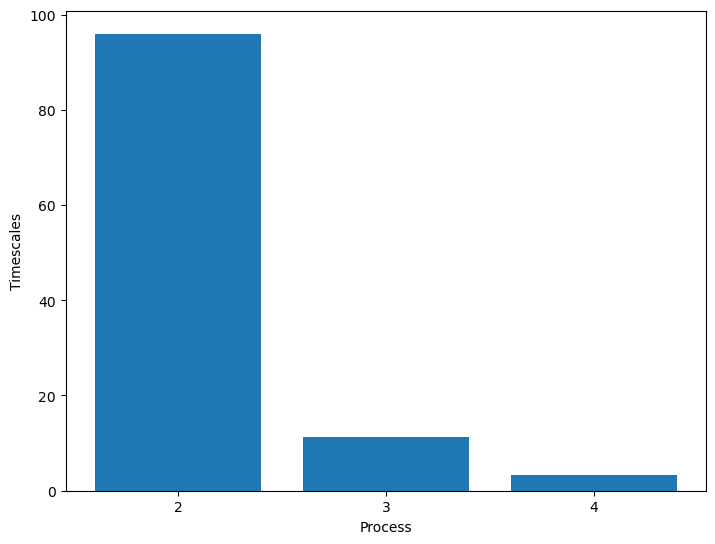

In [1136]:
discretization_values = [3, 10, 100, 1000]

for discretization_value in discretization_values:
    print("------------------------------------")
    print("Discretization Value:", discretization_value)
    print("------------------------------------")
    num_clusters = discretization_value
    states = get_state_clustering(num_clusters)
    count_matrix = get_count_matrix(states, num_clusters)
    transition_matrix = get_transition_matrix(count_matrix, num_clusters)
    macrostates = calculate_macro_staes(transition_matrix, num_clusters)
    eigen_tuples = get_eigenvalues(transition_matrix)
    timescales = get_timescales(eigen_tuples, 1)

Applying the same procedure as before but for a different number of states, we observe some changes which are not far from what is expected. 

Previously we concluded that there were 2 macrostates for a number of 100 clusters. Though, for a number of 3 and 10 clusters we observe 3 

macrostates and for 1000 clusters we observe 4 macrostates. Utilizing a low number of clusters could underfit the data and a high number of 

clusters could overfit the data. We can argue about the existence of 3 macrostates like previously stated.

As for the estimated timescale for each number of clusters:

- For 3 clusters, we have extremely large timescales for the slowest process indicating either too simple of a model or a stable system which 
  
  is less likely.

- For 10 clusters, we find significantly smaller timescales for the slowest process indicating a more complex model but still possibly missing 
  
  out on important system dynamics.

- For 100 clusters, we yet again have a more refined model that caputres the middle between all the models. The timescale for the slowest 
  
  process could be more accurate.

- For 1000 clusters, we have a quite complex model that risks overfitting the data. If this is the case, the timescale for the slowest process 
  
  could be less accurate.

In conclusion, it is important to choose a level of discretization that captures the essential dynamics without overcomplicating the model.